# Saving Array Quantities

## Overview

### Questions

* How can I save per-particle quantities for later analysis?
* How can I access that data?

### Objectives

* Show how to log **per-particle properties** to a **GSD** file.
* Explain how to read logged quantities from a **GSD** file.
* Mention that OVITO reads these quantities.

## Boilerplate code

In [1]:
import hoomd
import numpy
import gsd.hoomd
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

## Array quantities

You logged a 6-element array quantity in the previous section, the pressure tensor.
You can also log larger arrays and per-particle quantities (e.g. energy and force) in a **GSD** file along with the trajectory.
Then you can use utilize the data in your analysis and visualization workflow, such as using [OVITO](https://www.ovito.org/) to color particles by energy or display force vectors.
When using OVITO, open the **GSD** file and all logged quantities will be available in the inspector and for use in the pipeline.

## Define the Simulation

This tutorial executes the Lennard-Jones particle simulation from a previous tutorial. 
See [*Introducing Molecular Dyamics*](../01-Introducing-Molecular-Dynamics/00-index.ipynb) for a complete description of this code.

In [2]:
gpu = hoomd.device.GPU()
sim = hoomd.Simulation(device=gpu)
sim.create_state_from_gsd(filename='../01-Introducing-Molecular-Dynamics/random.gsd')

integrator = hoomd.md.Integrator(dt=0.005)
cell = hoomd.md.nlist.Cell()
lj = hoomd.md.pair.LJ(nlist=cell)
lj.params[('A', 'A')] = dict(epsilon=1, sigma=1)
lj.r_cut[('A', 'A')] = 2.5
integrator.forces.append(lj)
nvt = hoomd.md.methods.NVT(kT=1.5, filter=hoomd.filter.All(), tau=1.0)
integrator.methods.append(nvt)
sim.operations.integrator = integrator
sim.run(0)

## Logging per-particle quantities

MD forces provide a number of loggable quantities including their contribution to the system energy, but also per-particle energy contributions (in `energies`) and per-particle forces, torques, and virials.

In [3]:
lj.loggables

{'state': 'state',
 'energy': 'scalar',
 'energies': 'particle',
 'forces': 'particle',
 'torques': 'particle',
 'virials': 'particle'}

Add the per-particle LJ energies and forces to a logger:

In [4]:
logger = hoomd.logging.Logger()
logger.add(lj, quantities=['energies', 'forces'])

[('md', 'pair', 'LJ', 'energies'), ('md', 'pair', 'LJ', 'forces')]

## Writing per-particle quantities to a GSD file

In the previous section, you used a `Null` filter to produce GSD file with *only* logged data.
In this section, include all particles so that you can associate logged per-particle quantities with the particle properties.


In [5]:
gsd_writer = hoomd.write.GSD(filename='trajectory.gsd',
                             trigger=hoomd.trigger.Periodic(10000),
                             mode='wb',
                             filter=hoomd.filter.All(),
                             log=logger)
sim.operations.writers.append(gsd_writer)

Run the simulation:

In [6]:
sim.run(100000)

You need to close the **GSD** file that `gsd_writer` has open before you can read it.
The following code block deletes the simulation and operations manually so that it is safe to open the file for reading later in the notebook.

In typical workflows, you will run simulations and analysis scripts separately and this will happen automatically.

In [7]:
del sim, gsd_writer, logger, integrator, nvt, lj, cell, gpu

## Reading logged data from a GSD file

Use the `gsd` package to open the file:

In [8]:
traj = gsd.hoomd.open('trajectory.gsd', 'rb')

GSD prepends `particles/` to the logged name of per-particle quantities:

In [9]:
traj[0].log.keys()

dict_keys(['particles/md/pair/LJ/energies', 'particles/md/pair/LJ/forces'])

The quantities are numpy arrays with `N_particles` elements.
Here are a few slices:

In [10]:
traj[-1].log['particles/md/pair/LJ/energies'][0:10]

array([-5.45802769, -4.27912184, -5.15478744, -4.6809711 , -5.15165893,
       -4.81411452, -1.20014649, -3.97002736, -5.17438354, -3.74666524])

In [11]:
traj[-1].log['particles/md/pair/LJ/forces'][0:10]

array([[ -6.1692878 , -10.35113615,  -2.26969905],
       [-11.788292  ,  -0.11124408,   7.50452896],
       [  8.65083714, -23.90877246,  18.41154837],
       [  6.54789054,  -8.50041979,  -2.80315614],
       [  2.3447904 ,   6.38613576,   6.00988663],
       [ 17.60066803,  10.98374793,  15.46993776],
       [ 28.24818871, -87.09237105,  68.08554327],
       [ 40.28462545,  -0.39114585,  -4.2151023 ],
       [ 30.55242594,  20.17914196, -16.07433798],
       [ 30.33513634, -26.74972978,   7.80888522]])

You can use these arrays as inputs to any computation or plotting tools:

In [12]:
numpy.mean(traj[-1].log['particles/md/pair/LJ/forces'], axis=0)

array([ 5.68434189e-17, -6.89226454e-16,  1.98951966e-16])

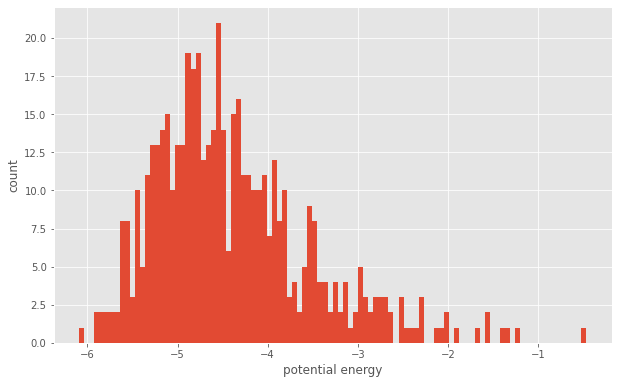

In [13]:
fig = matplotlib.figure.Figure(figsize=(10, 6.18))
ax = fig.add_subplot()
ax.hist(traj[-1].log['particles/md/pair/LJ/energies'], 100)
ax.set_xlabel('potential energy')
ax.set_ylabel('count')
fig

As with scalar quantities, the array quantities are stored separately in each frame.
Use a loop to access a range of frames and compute time-series data or averages.

In this section, you have logged per-particle quantities to a GSD file during a simulation run and accessed that data with a script.
The next section of this tutorial will demonstrate how to log particle shape information that OVITO can use.

[Previous section](02-Writing-to-a-File.ipynb) / [Next section](04-Storing-Particle-Shape.ipynb)